# Background
With the current pandemic environment creating a WFH(Work From
Home) environment for a majority of jobs, I wanted to analyze and create
an engine that would allow looking at alternative locations for us to live
that would allow us to be closer to venues we like (i.e. nice restaurants,
parks, live music/theatre) and possibly closer to where our daughter may
be attending college in 2021.
Since WFH allows us not to be in the cities where companies are, we
can begin to expand ideas on where we might want to relocate. This
could be utilized as the "engine" behind a GUI front-end for
persons/families to pick their own city destinations and categories of
venues for their decision-making process.

# Data:
I will be using the Foursquare API data to identify venues for 3 potential
cities that may be where we want to relocate based on our desire to be
closer to our daughter's possible college choices and cities we've visited
and like the general feel, but don't know much about the area, where we
could live close to venues we like. As stated, we don't need to look at
schools, but do like parks, restaurants, and music/entertainment venues.
Also, we want to look at the housing costs, and the supply/demand of
housing in those cities by zip code.
To do this, I will use the Foursquare data to get the venues (and
categories) for the cities of Kansas City, Missouri (we live in a suburb of
Kansas City, but would love to move downtown if we stayed once our
daughter was off to college), Fort Collins, CO, and Portland, OR.
For the data on housing data, I will use data from Realtor.com
(specifically, RDC_Inventory_Hotness_Metrics_Zip_History) that has
current data (202004) on Housing inventory and hotness metric data that
will supply the median_listing_prices, supply_score, demand_score, and
median_listing_price_vs_us by zip code. This data will allow us to look at
the three cities and compare the median housing price, the comparisonto the median price to rest of US (our current zip code is a +2 from the
median price in US), and a gauge on the supply/demand index
calculated by Realtors.com (high # up to 100 is the level of either
category) to gauge the housing market in that city.
All this data will allow us to compare zip codes(areas) in those cities that
would be best suited for starting a search as well as compare cities to
help in our decision.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


##  First location: Kansas City, MO

In [2]:
address = 'Kansas City, MO'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kansas City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Kansas City are 39.100105, -94.5781416.


In [5]:
CLIENT_ID = 'ZYXIMSWSAC1T405TZAKQ0LL2JNEZMBAZGTI01TXRETET4330' # Foursquare ID
CLIENT_SECRET = 'PDNOOER0EZM3PTQTATEDWDGMYYZ44FUIHLG0GMZZWZGLRTM3' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

My credentials:
CLIENT_ID: ZYXIMSWSAC1T405TZAKQ0LL2JNEZMBAZGTI01TXRETET4330
CLIENT_SECRET: PDNOOER0EZM3PTQTATEDWDGMYYZ44FUIHLG0GMZZWZGLRTM3


In [7]:
limit = 200 # limit of number of venues returned by Foursquare API
radius = 4000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=39.100105,-94.5781416&radius=4000&limit=200'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, limit)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=39.100105,-94.5781416&radius=4000&limit=200'

In [12]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f51323fd260820eeccaadf0'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Kansas City',
  'headerFullLocation': 'Kansas City',
  'headerLocationGranularity': 'city',
  'totalResults': 204,
  'suggestedBounds': {'ne': {'lat': 39.13610503600003,
    'lng': -94.53183911988859},
   'sw': {'lat': 39.06410496399997, 'lng': -94.6244440801114}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5422006a498e41bc7ee2b6a0',
       'name': 'Onelife Fitness',
       'location': {'address': '1261 Main St',
        'crossStreet': 'at E 13th St',
        'lat': 39.098829,
        'lng': -94.582885,
        'labeledLatLngs

In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']
    
KCnearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
KCnearby_venues =KCnearby_venues.loc[:, filtered_columns]

# filter the category for each row
KCnearby_venues['venue.categories'] = KCnearby_venues.apply(get_category_type, axis=1)

# clean columns
KCnearby_venues.columns = [col.split(".")[-1] for col in KCnearby_venues.columns]

KCnearby_venues.head(10)

,name,categories,lat,lng,postalCode
0,Onelife Fitness,Gym,39.098829,-94.582885,64105
1,Reserve,New American Restaurant,39.100632,-94.580657,64106
2,Alamo Drafthouse Cinema,Movie Theater,39.097091,-94.583611,64105
3,Cosentino's Market Downtown,Supermarket,39.098676,-94.582964,64106
4,Polished Nail Salon,Salon / Barbershop,39.099604,-94.583052,64105
5,T-Mobile Center,Stadium,39.097276,-94.580015,64106
6,Bristol Seafood Grill,Seafood Restaurant,39.097064,-94.582879,64106
7,Zoo Bar,Dive Bar,39.099415,-94.579793,64106
8,Messenger Coffee Co.,Coffee Shop,39.093469,-94.581503,64108
9,Arvest Bank Theatre at the Midland,Music Venue,39.098883,-94.583731,64105


In [16]:
print('{} venues were returned by Foursquare.'.format(KCnearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [28]:
# create map of Kansas City using latitude and longitude values
map_KC = folium.Map(location=[latitude, longitude], zoom_start=16)

# add markers to map
for lat, lng, label in zip(KCnearby_venues['lat'], KCnearby_venues['lng'], KCnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=4,
        radius=5,
        popup=label,
        color='darkblue',
        fill_color='blue',
        fill_opacity=0.9,
    ).add_to(map_KC)  
    
map_KC

# Second Location Fort Collins, CO

In [29]:

address = 'Fort Collins, CO'

geolocator = Nominatim(user_agent="foursquare_agent2")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Fort Collins are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Fort Collins are 40.5508527, -105.0668085.


In [30]:
limit = 200 # limit of number of venues returned by Foursquare API
radius = 4000 # define radius

# create URL
url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=40.5508527,-105.0668085&radius=4000&limit=200'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, limit)
url2 # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=40.5508527,-105.0668085&radius=4000&limit=200'

In [34]:
results = requests.get(url2).json()
#results

In [37]:
venues = results['response']['groups'][0]['items']
    
COnearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
COnearby_venues =COnearby_venues.loc[:, filtered_columns]

# filter the category for each row
COnearby_venues['venue.categories'] = COnearby_venues.apply(get_category_type, axis=1)

# clean columns
COnearby_venues.columns = [col.split(".")[-1] for col in COnearby_venues.columns]

COnearby_venues.head(10)

,name,categories,lat,lng,postalCode
0,Spring Creek Trail,Trail,40.550484,-105.072643,80525
1,Star of India,Indian Restaurant,40.549033,-105.076043,80525
2,Maxline Brewing,Brewery,40.549659,-105.079270,80525
3,Sprouts Farmers Market,Grocery Store,40.550660,-105.059595,80525
4,Cinemark,Movie Theater,40.541727,-105.072320,80525
5,Great Harvest Bread Co.,Bakery,40.550959,-105.059521,80525
6,Wilbur's Total Beverage,Liquor Store,40.559032,-105.078700,80525
7,Rise! A Breakfast Place,Breakfast Spot,40.550425,-105.058501,80525
8,Floyd's 99 Barbershop,Cosmetics Shop,40.559722,-105.077434,80525
9,Elevation 5003 Distillery,Whisky Bar,40.550959,-105.059521,80525


In [38]:
print('{} venues were returned by Foursquare.'.format(COnearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [41]:
# create map of Fort Collins using latitude and longitude values
map_CO = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(COnearby_venues['lat'], COnearby_venues['lng'], COnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=3,
        radius=10,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=0.7,
    ).add_to(map_CO)  
    
map_CO

#  Third Location Portland, OR

In [42]:
address = 'Portland, OR'

geolocator = Nominatim(user_agent="foursquare_agent3")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Portland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Portland are 45.5202471, -122.6741949.


In [43]:
limit = 200 # limit of number of venues returned by Foursquare API
radius = 4000 # define radius

# create URL
url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=45.5202471,-122.6741949&radius=4000&limit=200'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, limit)
url3 # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=45.5202471,-122.6741949&radius=4000&limit=200'

In [44]:
results = requests.get(url3).json()
#results

In [54]:
    
ORnearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
ORnearby_venues =ORnearby_venues.loc[:, filtered_columns]

# filter the category for each row
ORnearby_venues['venue.categories'] = ORnearby_venues.apply(get_category_type, axis=1)

# clean columns
ORnearby_venues.columns = [col.split(".")[-1] for col in ORnearby_venues.columns]

ORnearby_venues.head(10)

,name,categories,lat,lng,postalCode
0,Spring Creek Trail,Trail,40.550484,-105.072643,80525
1,Star of India,Indian Restaurant,40.549033,-105.076043,80525
2,Maxline Brewing,Brewery,40.549659,-105.079270,80525
3,Sprouts Farmers Market,Grocery Store,40.550660,-105.059595,80525
4,Cinemark,Movie Theater,40.541727,-105.072320,80525
5,Great Harvest Bread Co.,Bakery,40.550959,-105.059521,80525
6,Wilbur's Total Beverage,Liquor Store,40.559032,-105.078700,80525
7,Rise! A Breakfast Place,Breakfast Spot,40.550425,-105.058501,80525
8,Floyd's 99 Barbershop,Cosmetics Shop,40.559722,-105.077434,80525
9,Elevation 5003 Distillery,Whisky Bar,40.550959,-105.059521,80525


In [55]:
print('{} venues were returned by Foursquare.'.format(ORnearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [63]:
# create map of Portland using latitude and longitude values
map_OR = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
for lat, lng, label in zip(ORnearby_venues['lat'], ORnearby_venues['lng'], ORnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=5,
        radius=10,
        popup=label,
        color='green',
        fill_color='green',
        fill_opacity=0.9,
    ).add_to(map_OR)  
    
map_OR

# Retrieving housing cost/affordability information from Realtor.com data

In [65]:
df = pd.read_csv("RDC_Inventory_Hotness_Metrics_Zip_History.csv")
df.head()

/home/basem/anaconda3/envs/coursera_capstone/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,month_date_yyyymm,postal_code,zip_name,nielsen_hh_rank,hotness_rank,hotness_rank_mm,hotness_rank_yy,hotness_score,supply_score,demand_score,median_days_on_market,median_days_on_market_mm,median_dom_mm_day,median_days_on_market_yy,median_dom_yy_day,median_dom_vs_us,ldpviews_per_property_mm,ldpviews_per_property_yy,ldpviews_per_property_vs_us,median_listing_price,median_listing_price_mm,median_listing_price_yy,median_listing_price_vs_us
0,202008,8109,"merchantville, nj",5522.0,79.0,724.0,1378.0,98.425227,97.658812,99.191642,20.0,-0.4872,-19.0,-0.5556,-25.0,-36.0,0.3093,2.8637,3.7285,214950.0,0.1137,0.1148,0.6142
1,202008,59930,"rexford, mt",22470.0,11970.0,206.0,3678.0,14.615267,3.431709,25.798826,172.0,0.0330,5.5,0.4957,57.0,116.0,0.0753,2.8674,0.6623,369050.0,0.0000,-0.0237,1.0546
2,202008,60515,"downers grove, il",3553.0,5650.0,-394.0,1993.0,54.663311,65.293983,44.032639,44.0,-0.0112,-0.5,-0.1698,-9.0,-12.0,0.0494,1.3110,0.9139,499950.0,0.0525,0.1822,1.4287
3,202008,72650,"marshall, ar",14028.0,11318.0,859.0,4435.0,19.808587,13.139632,26.477541,102.0,-0.2416,-32.5,-0.5467,-123.0,46.0,0.2000,2.0644,0.6755,93550.0,-0.0106,-0.0510,0.2672
4,202008,95033,"los gatos, ca",9768.0,8734.0,-2369.0,-1538.0,37.295051,20.285213,54.304888,84.0,0.2727,18.0,0.2727,18.0,28.0,-0.0663,0.9220,1.0728,1410050.0,-0.0569,-0.0321,4.0297


In [66]:
df.shape

(783514, 23)

In [67]:
df_real = df[['month_date_yyyymm', 'postal_code', 'hotness_rank', 'supply_score', 'demand_score', 'median_listing_price', 'median_listing_price_vs_us']]

In [68]:
df_real.head()

,month_date_yyyymm,postal_code,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us
0,202008,8109,79.0,97.658812,99.191642,214950.0,0.6142
1,202008,59930,11970.0,3.431709,25.798826,369050.0,1.0546
2,202008,60515,5650.0,65.293983,44.032639,499950.0,1.4287
3,202008,72650,11318.0,13.139632,26.477541,93550.0,0.2672
4,202008,95033,8734.0,20.285213,54.304888,1410050.0,4.0297


In [83]:
# Clean-up/Simplify the realty data as there are many of the 23 fields that we don't need when we merge with our foursquare data.
df_real = df_real.astype({"month_date_yyyymm": str})
df_real.head()

,month_date_yyyymm,postal_code,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us
0,202008,8109,79.0,97.658812,99.191642,214950.0,0.6142
1,202008,59930,11970.0,3.431709,25.798826,369050.0,1.0546
2,202008,60515,5650.0,65.293983,44.032639,499950.0,1.4287
3,202008,72650,11318.0,13.139632,26.477541,93550.0,0.2672
4,202008,95033,8734.0,20.285213,54.304888,1410050.0,4.0297


## As dataset has historical data, only wanted to get the most current data for my analysis

In [84]:
cur_real = df_real[(df_real.month_date_yyyymm == "202008")]
cur_real.tail(15)

,month_date_yyyymm,postal_code,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us
13079,202008,2330,4346.0,42.278655,81.362007,429050.0,1.2261
13080,202008,54636,7748.0,25.592923,61.061542,298050.0,0.8517
13081,202008,75217,3138.0,56.684207,82.643179,175050.0,0.5001
13082,202008,91335,3954.0,60.306566,68.199497,650050.0,1.8577
13083,202008,70791,11941.0,19.049798,10.653550,299950.0,0.8571
13084,202008,11005,9472.0,65.293983,0.190651,529050.0,1.5119
13085,202008,65686,3141.0,45.481583,93.838176,264950.0,0.7571
13086,202008,7760,6114.0,38.000458,66.422634,1649050.0,4.7128
13087,202008,19002,5360.0,26.004728,86.318920,899950.0,2.5719
13088,202008,54944,5380.0,36.429497,75.665370,379950.0,1.0857


In [85]:
cur_real.shape

(13094, 7)

### rename DF label to allow for merging with the Foursquare DF for each city

In [86]:
cur_real = cur_real.rename(columns={'postal_code':'postalCode'})
cur_real.head()

,month_date_yyyymm,postalCode,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us
0,202008,8109,79.0,97.658812,99.191642,214950.0,0.6142
1,202008,59930,11970.0,3.431709,25.798826,369050.0,1.0546
2,202008,60515,5650.0,65.293983,44.032639,499950.0,1.4287
3,202008,72650,11318.0,13.139632,26.477541,93550.0,0.2672
4,202008,95033,8734.0,20.285213,54.304888,1410050.0,4.0297


In [87]:
# Convert postalCode to same datatype before merging
cur_real = cur_real.astype({"postalCode": str})
cur_real.head()

,month_date_yyyymm,postalCode,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us
0,202008,8109,79.0,97.658812,99.191642,214950.0,0.6142
1,202008,59930,11970.0,3.431709,25.798826,369050.0,1.0546
2,202008,60515,5650.0,65.293983,44.032639,499950.0,1.4287
3,202008,72650,11318.0,13.139632,26.477541,93550.0,0.2672
4,202008,95033,8734.0,20.285213,54.304888,1410050.0,4.0297


In [88]:
KCnearby_venues.head()

,name,categories,lat,lng,postalCode
0,Onelife Fitness,Gym,39.098829,-94.582885,64105
1,Reserve,New American Restaurant,39.100632,-94.580657,64106
2,Alamo Drafthouse Cinema,Movie Theater,39.097091,-94.583611,64105
3,Cosentino's Market Downtown,Supermarket,39.098676,-94.582964,64106
4,Polished Nail Salon,Salon / Barbershop,39.099604,-94.583052,64105


In [89]:
KC_geo2 = pd.merge(KCnearby_venues, cur_real, on='postalCode', how='left', indicator=True)
KC_geo2.head(10)

,name,categories,lat,lng,postalCode,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
0,Onelife Fitness,Gym,39.098829,-94.582885,64105,202008,10335.0,30.099901,23.854191,213950.0,0.6113,both
1,Reserve,New American Restaurant,39.100632,-94.580657,64106,202008,9815.0,47.685503,13.116754,244550.0,0.6988,both
2,Alamo Drafthouse Cinema,Movie Theater,39.097091,-94.583611,64105,202008,10335.0,30.099901,23.854191,213950.0,0.6113,both
3,Cosentino's Market Downtown,Supermarket,39.098676,-94.582964,64106,202008,9815.0,47.685503,13.116754,244550.0,0.6988,both
4,Polished Nail Salon,Salon / Barbershop,39.099604,-94.583052,64105,202008,10335.0,30.099901,23.854191,213950.0,0.6113,both
5,T-Mobile Center,Stadium,39.097276,-94.580015,64106,202008,9815.0,47.685503,13.116754,244550.0,0.6988,both
6,Bristol Seafood Grill,Seafood Restaurant,39.097064,-94.582879,64106,202008,9815.0,47.685503,13.116754,244550.0,0.6988,both
7,Zoo Bar,Dive Bar,39.099415,-94.579793,64106,202008,9815.0,47.685503,13.116754,244550.0,0.6988,both
8,Messenger Coffee Co.,Coffee Shop,39.093469,-94.581503,64108,202008,8361.0,61.236940,17.822009,315000.0,0.9001,both
9,Arvest Bank Theatre at the Midland,Music Venue,39.098883,-94.583731,64105,202008,10335.0,30.099901,23.854191,213950.0,0.6113,both


In [91]:
KC_geo2.shape

(100, 12)

In [92]:
KC_geo2.groupby('postalCode').count()

,name,categories,lat,lng,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
postalCode,,,,,,,,,,,
64101,1,1,1,1,0,0,0,0,0,0,1
64105,28,28,28,28,28,28,28,28,28,28,28
64106,28,28,28,28,28,28,28,28,28,28,28
64108,42,42,42,42,42,42,42,42,42,42,42
64120,1,1,1,1,0,0,0,0,0,0,1


In [93]:
print('There are {} unique categories.'.format(len(KC_geo2['categories'].unique())))

There are 66 unique categories.


## analyze venue categories in each KC ZipCoded

In [94]:
# one hot encoding
KC_onehot = pd.get_dummies(KC_geo2[['categories']], prefix="", prefix_sep="")

# add postalCode column back to dataframe
KC_onehot['postalCode'] = KC_geo2['postalCode']

# move postalCode column to the first column
fixed_columns = [KC_onehot.columns[-1]] + list(KC_onehot.columns[:-1])
KC_onehot = KC_onehot[fixed_columns]

KC_onehot.head()

,postalCode,American Restaurant,Antique Shop,Arcade,Arts & Crafts Store,BBQ Joint,Bakery,Beer Garden,Brazilian Restaurant,Brewery,Bridge,Burger Joint,Burrito Place,Café,Candy Store,Cocktail Bar,Coffee Shop,Deli / Bodega,Distillery,Dive Bar,Dog Run,Ethiopian Restaurant,Farmers Market,Food Court,French Restaurant,Gastropub,German Restaurant,Grocery Store,Gym,Health Food Store,Herbs & Spices Store,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Italian Restaurant,Jazz Club,Library,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Park,Performing Arts Venue,Pizza Place,Plaza,Poke Place,Print Shop,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Speakeasy,Sports Bar,Stadium,Steakhouse,Supermarket,Taco Place,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,64105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,64106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,64105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,64106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,64105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [95]:
KC_onehot.shape

(100, 67)

In [96]:
KC_grouped = KC_onehot.groupby('postalCode').mean().reset_index()
KC_grouped

,postalCode,American Restaurant,Antique Shop,Arcade,Arts & Crafts Store,BBQ Joint,Bakery,Beer Garden,Brazilian Restaurant,Brewery,Bridge,Burger Joint,Burrito Place,Café,Candy Store,Cocktail Bar,Coffee Shop,Deli / Bodega,Distillery,Dive Bar,Dog Run,Ethiopian Restaurant,Farmers Market,Food Court,French Restaurant,Gastropub,German Restaurant,Grocery Store,Gym,Health Food Store,Herbs & Spices Store,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Italian Restaurant,Jazz Club,Library,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Park,Performing Arts Venue,Pizza Place,Plaza,Poke Place,Print Shop,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Speakeasy,Sports Bar,Stadium,Steakhouse,Supermarket,Taco Place,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,64101,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000
1,64105,0.071429,0.035714,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.035714,0.035714,0.00000,0.0,0.107143,0.000000,0.000000,0.035714,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.035714,0.035714,0.000000,0.000000,0.000000,0.035714,0.00000,0.035714,0.035714,0.035714,0.035714,0.00000,0.00000,0.035714,0.035714,0.00000,0.035714,0.000000,0.071429,0.00000,0.071429,0.035714,0.035714,0.00000,0.00000,0.035714,0.000000,0.000000,0.00000,0.000000,0.000000,0.035714,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000
2,64106,0.035714,0.000000,0.00000,0.00000,0.035714,0.035714,0.035714,0.035714,0.035714,0.000000,0.035714,0.000000,0.000000,0.00000,0.0,0.000000,0.035714,0.000000,0.035714,0.0,0.035714,0.035714,0.00000,0.071429,0.000000,0.00000,0.000000,0.000000,0.035714,0.035714,0.035714,0.000000,0.00000,0.000000,0.035714,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.035714,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.071429,0.035714,0.00000,0.071429,0.035714,0.000000,0.035714,0.035714,0.00000,0.00000,0.00000,0.071429,0.00000,0.00000
3,64108,0.047619,0.000000,0.02381,0.02381,0.023810,0.000000,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,0.02381,0.0,0.095238,0.000000,0.047619,0.000000,0.0,0.000000,0.000000,0.02381,0.023810,0.047619,0.02381,0.000000,0.023810,0.000000,0.000000,0.023810,0.000000,0.02381,0.000000,0.000000,0.000000,0.000000,0.02381,0.02381,0.000000,0.000000,0.02381,0.047619,0.047619,0.000000,0.02381,0.047619,0.000000,0.000000,0.02381,0.02381,0.000000,0.000000,0.000000,0.02381,0.000000,0.000000,0.000000,0.000000,0.000000,0.02381,0.02381,0.02381,0.000000,0.02381,0.02381
4,64120,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000


In [98]:
num_top_venues = 5
for hood in KC_grouped['postalCode']:
    print("----"+hood+"----")
    temp = KC_grouped[KC_grouped['postalCode'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----64101----
                     venue  freq
0             Cocktail Bar   1.0
1      American Restaurant   0.0
2  New American Restaurant   0.0
3               Poke Place   0.0
4                    Plaza   0.0


----64105----
                       venue  freq
0                Coffee Shop  0.11
1        American Restaurant  0.07
2                Pizza Place  0.07
3                       Park  0.07
4  Middle Eastern Restaurant  0.04


----64106----
                   venue  freq
0  Vietnamese Restaurant  0.07
1         Sandwich Place  0.07
2      French Restaurant  0.07
3             Sports Bar  0.07
4    American Restaurant  0.04


----64108----
                 venue  freq
0              Brewery  0.10
1          Coffee Shop  0.10
2  American Restaurant  0.05
3           Distillery  0.05
4          Pizza Place  0.05


----64120----
                 venue  freq
0              Dog Run   1.0
1  American Restaurant   0.0
2           Print Shop   0.0
3              Library   0.0
4        

In [99]:
# Let's put this analysis into a Pandas dataframe

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [100]:
# Creating the dataframe and display the top 5 venues for each postalCode

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
KC_venues_sorted = pd.DataFrame(columns=columns)
KC_venues_sorted['postalCode'] = KC_grouped['postalCode']

for ind in np.arange(KC_grouped.shape[0]):
    KC_venues_sorted.iloc[ind, 1:] = return_most_common_venues(KC_grouped.iloc[ind, :], num_top_venues)
    
KC_venues_sorted.head()

,postalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,64101,Cocktail Bar,Wine Shop,French Restaurant,Dive Bar,Dog Run
1,64105,Coffee Shop,American Restaurant,Park,Pizza Place,Salon / Barbershop
2,64106,Sandwich Place,Vietnamese Restaurant,French Restaurant,Sports Bar,Beer Garden
3,64108,Coffee Shop,Brewery,American Restaurant,Pizza Place,Gastropub
4,64120,Dog Run,Wine Shop,Deli / Bodega,History Museum,Herbs & Spices Store


### So this gives us a better visual of the categories of venues in each KC Zip Code - helpful to get a sense of areas we may want to focus on regarding housing¶
 as stated in the Introduction, we like Parks and Music venues but we also like Breweries and fun restaurants so we may begin looking at zipcode 64108 and then look at housing data

## Now let's do the same analysis for Fort Collins, CO

In [102]:
CO_geo2 = pd.merge(COnearby_venues, cur_real, on='postalCode', how='left', indicator=True)
CO_geo2.head(10)

,name,categories,lat,lng,postalCode,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
0,Spring Creek Trail,Trail,40.550484,-105.072643,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
1,Star of India,Indian Restaurant,40.549033,-105.076043,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
2,Maxline Brewing,Brewery,40.549659,-105.079270,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
3,Sprouts Farmers Market,Grocery Store,40.550660,-105.059595,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
4,Cinemark,Movie Theater,40.541727,-105.072320,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
5,Great Harvest Bread Co.,Bakery,40.550959,-105.059521,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
6,Wilbur's Total Beverage,Liquor Store,40.559032,-105.078700,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
7,Rise! A Breakfast Place,Breakfast Spot,40.550425,-105.058501,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
8,Floyd's 99 Barbershop,Cosmetics Shop,40.559722,-105.077434,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
9,Elevation 5003 Distillery,Whisky Bar,40.550959,-105.059521,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both


In [103]:
CO_geo2.groupby('postalCode').count()

,name,categories,lat,lng,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
postalCode,,,,,,,,,,,
80521,5,5,5,5,5,5,5,5,5,5,5
80523,1,1,1,1,0,0,0,0,0,0,1
80524,15,15,15,15,15,15,15,15,15,15,15
80525,66,66,66,66,66,66,66,66,66,66,66
80526,8,8,8,8,8,8,8,8,8,8,8


In [104]:
print('There are {} unique categories.'.format(len(CO_geo2['categories'].unique())))

There are 59 unique categories.


In [105]:
# nalyze venue categories in each Fort Collins ZipCodes

In [106]:
# one hot encoding
CO_onehot = pd.get_dummies(CO_geo2[['categories']], prefix="", prefix_sep="")

# add postalCode column back to dataframe
CO_onehot['postalCode'] = CO_geo2['postalCode']

# move postalCode column to the first column
fixed_columns = [CO_onehot.columns[-1]] + list(CO_onehot.columns[:-1])
CO_onehot = CO_onehot[fixed_columns]

CO_onehot.head()

,postalCode,American Restaurant,Asian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Chinese Restaurant,Church,Coffee Shop,College Bookstore,Cosmetics Shop,Costume Shop,Deli / Bodega,Disc Golf,Discount Store,Donut Shop,Fast Food Restaurant,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Grocery Store,Gym,Gym / Fitness Center,Indian Restaurant,Italian Restaurant,Liquor Store,Market,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Noodle House,Park,Pet Store,Pizza Place,Sandwich Place,Seafood Restaurant,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Taco Place,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vietnamese Restaurant,Whisky Bar,Wine Bar
0,80525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,80525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,80525,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,80525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,80525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [107]:
CO_grouped = CO_onehot.groupby('postalCode').mean().reset_index()
CO_grouped

,postalCode,American Restaurant,Asian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Chinese Restaurant,Church,Coffee Shop,College Bookstore,Cosmetics Shop,Costume Shop,Deli / Bodega,Disc Golf,Discount Store,Donut Shop,Fast Food Restaurant,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Grocery Store,Gym,Gym / Fitness Center,Indian Restaurant,Italian Restaurant,Liquor Store,Market,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Noodle House,Park,Pet Store,Pizza Place,Sandwich Place,Seafood Restaurant,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Taco Place,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vietnamese Restaurant,Whisky Bar,Wine Bar
0,80521,0.000000,0.000000,0.000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
1,80523,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,80524,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.0,0.000000,0.000000,0.133333,0.0,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.133333,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000,0.000000,0.066667,0.000000,0.066667
3,80525,0.030303,0.015152,0.000,0.015152,0.0,0.015152,0.000000,0.015152,0.015152,0.030303,0.090909,0.015152,0.000000,0.0,0.015152,0.015152,0.075758,0.0,0.015152,0.015152,0.000000,0.015152,0.015152,0.030303,0.030303,0.015152,0.030303,0.015152,0.015152,0.000,0.060606,0.030303,0.015152,0.015152,0.015152,0.015152,0.0,0.015152,0.045455,0.015152,0.015152,0.015152,0.030303,0.000000,0.000000,0.015152,0.015152,0.000000,0.000000,0.015152,0.015152,0.015152,0.000000,0.015152,0.000,0.015152,0.030303,0.030303,0.000000
4,80526,0.000000,0.000000,0.125,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.125000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000


In [109]:
num_top_venues = 5

for hood in CO_grouped['postalCode']:
    print("----"+hood+"----")
    temp = CO_grouped[CO_grouped['postalCode'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----80521----
                       venue  freq
0                        Bar   0.2
1                    Theater   0.2
2                       Park   0.2
3  Cajun / Creole Restaurant   0.2
4                Pizza Place   0.2


----80523----
                  venue  freq
0     College Bookstore   1.0
1   American Restaurant   0.0
2         Grocery Store   0.0
3  Gym / Fitness Center   0.0
4     Indian Restaurant   0.0


----80524----
                  venue  freq
0           Coffee Shop  0.13
1        Sandwich Place  0.13
2         Burrito Place  0.07
3          Liquor Store  0.07
4  Fast Food Restaurant  0.07


----80525----
                 venue  freq
0              Brewery  0.09
1          Coffee Shop  0.08
2        Grocery Store  0.06
3   Mexican Restaurant  0.05
4  American Restaurant  0.03


----80526----
              venue  freq
0       Pizza Place  0.25
1            Garden  0.12
2  Toy / Game Store  0.12
3        Donut Shop  0.12
4       Coffee Shop  0.12




In [110]:
def return_most_common_venues(row, num_top_venues):
    row_categories2 = row.iloc[1:]
    row_categories_sorted2 = row_categories2.sort_values(ascending=False)
    
    return row_categories_sorted2.index.values[0:num_top_venues]

In [111]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
CO_venues_sorted = pd.DataFrame(columns=columns)
CO_venues_sorted['postalCode'] = CO_grouped['postalCode']

for ind in np.arange(CO_grouped.shape[0]):
    CO_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CO_grouped.iloc[ind, :], num_top_venues)
    
CO_venues_sorted.head()

,postalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,80521,Pizza Place,Bar,Park,Theater,Cajun / Creole Restaurant
1,80523,College Bookstore,Wine Bar,Chinese Restaurant,Fried Chicken Joint,Food Truck
2,80524,Coffee Shop,Sandwich Place,Wine Bar,Speakeasy,Deli / Bodega
3,80525,Brewery,Coffee Shop,Grocery Store,Mexican Restaurant,Pet Store
4,80526,Pizza Place,Coffee Shop,Donut Shop,Gym / Fitness Center,Garden


### So this gives us a better visual of the categories of venues in each Fort Collins Zip Code - helpful to get a sense of areas we may want to focus on regarding housing¶
as stated in the Introduction, we like Parks and Music/Theater venues so we may begin looking at zipcode 80521 and then look at housing data

## Now let's do the same analysis for Portland, OR

In [113]:
OR_geo2 = pd.merge(ORnearby_venues, cur_real, on='postalCode', how='inner', indicator=True)
OR_geo2.head(10)

,name,categories,lat,lng,postalCode,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
0,Spring Creek Trail,Trail,40.550484,-105.072643,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
1,Star of India,Indian Restaurant,40.549033,-105.076043,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
2,Maxline Brewing,Brewery,40.549659,-105.079270,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
3,Sprouts Farmers Market,Grocery Store,40.550660,-105.059595,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
4,Cinemark,Movie Theater,40.541727,-105.072320,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
5,Great Harvest Bread Co.,Bakery,40.550959,-105.059521,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
6,Wilbur's Total Beverage,Liquor Store,40.559032,-105.078700,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
7,Rise! A Breakfast Place,Breakfast Spot,40.550425,-105.058501,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
8,Floyd's 99 Barbershop,Cosmetics Shop,40.559722,-105.077434,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both
9,Elevation 5003 Distillery,Whisky Bar,40.550959,-105.059521,80525,202008,3468.0,84.442919,50.27835,455050.0,1.3004,both


In [114]:
OR_geo2.groupby('postalCode').count()

,name,categories,lat,lng,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
postalCode,,,,,,,,,,,
80521,5,5,5,5,5,5,5,5,5,5,5
80524,15,15,15,15,15,15,15,15,15,15,15
80525,66,66,66,66,66,66,66,66,66,66,66
80526,8,8,8,8,8,8,8,8,8,8,8


In [115]:
print('There are {} unique categories.'.format(len(OR_geo2['categories'].unique())))

There are 57 unique categories.


In [116]:
# one hot encoding
OR_onehot = pd.get_dummies(OR_geo2[['categories']], prefix="", prefix_sep="")

# add postalCode column back to dataframe
OR_onehot['postalCode'] = OR_geo2['postalCode']

# move postalCode column to the first column
fixed_columns = [OR_onehot.columns[-1]] + list(OR_onehot.columns[:-1])
OR_onehot = OR_onehot[fixed_columns]

OR_onehot.head()

,postalCode,American Restaurant,Asian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Chinese Restaurant,Church,Coffee Shop,Cosmetics Shop,Costume Shop,Deli / Bodega,Disc Golf,Discount Store,Donut Shop,Fast Food Restaurant,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Grocery Store,Gym,Gym / Fitness Center,Indian Restaurant,Italian Restaurant,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Noodle House,Park,Pet Store,Pizza Place,Sandwich Place,Seafood Restaurant,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Taco Place,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vietnamese Restaurant,Whisky Bar,Wine Bar
0,80525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,80525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,80525,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,80525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,80525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [117]:
OR_grouped = OR_onehot.groupby('postalCode').mean().reset_index()
OR_grouped

,postalCode,American Restaurant,Asian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Chinese Restaurant,Church,Coffee Shop,Cosmetics Shop,Costume Shop,Deli / Bodega,Disc Golf,Discount Store,Donut Shop,Fast Food Restaurant,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Grocery Store,Gym,Gym / Fitness Center,Indian Restaurant,Italian Restaurant,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Noodle House,Park,Pet Store,Pizza Place,Sandwich Place,Seafood Restaurant,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Taco Place,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vietnamese Restaurant,Whisky Bar,Wine Bar
0,80521,0.000000,0.000000,0.000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
1,80524,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.0,0.000000,0.000000,0.133333,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.133333,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000,0.000000,0.066667,0.000000,0.066667
2,80525,0.030303,0.015152,0.000,0.015152,0.0,0.015152,0.000000,0.015152,0.015152,0.030303,0.090909,0.015152,0.000000,0.0,0.015152,0.015152,0.075758,0.015152,0.015152,0.000000,0.015152,0.015152,0.030303,0.030303,0.015152,0.030303,0.015152,0.015152,0.000,0.060606,0.030303,0.015152,0.015152,0.015152,0.015152,0.015152,0.045455,0.015152,0.015152,0.015152,0.030303,0.000000,0.000000,0.015152,0.015152,0.000000,0.000000,0.015152,0.015152,0.015152,0.000000,0.015152,0.000,0.015152,0.030303,0.030303,0.000000
3,80526,0.000000,0.000000,0.125,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000


In [118]:
num_top_venues = 5

for hood in OR_grouped['postalCode']:
    print("----"+hood+"----")
    temp = OR_grouped[OR_grouped['postalCode'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----80521----
                       venue  freq
0                        Bar   0.2
1                    Theater   0.2
2                       Park   0.2
3  Cajun / Creole Restaurant   0.2
4                Pizza Place   0.2


----80524----
            venue  freq
0  Sandwich Place  0.13
1     Coffee Shop  0.13
2        Wine Bar  0.07
3     Pizza Place  0.07
4             Spa  0.07


----80525----
                 venue  freq
0              Brewery  0.09
1          Coffee Shop  0.08
2        Grocery Store  0.06
3   Mexican Restaurant  0.05
4  American Restaurant  0.03


----80526----
              venue  freq
0       Pizza Place  0.25
1            Garden  0.12
2  Toy / Game Store  0.12
3        Donut Shop  0.12
4       Coffee Shop  0.12




In [119]:
def return_most_common_venues(row, num_top_venues):
    row_categories3 = row.iloc[1:]
    row_categories_sorted3 = row_categories3.sort_values(ascending=False)
    
    return row_categories_sorted3.index.values[0:num_top_venues]

In [120]:
um_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
OR_venues_sorted = pd.DataFrame(columns=columns)
OR_venues_sorted['postalCode'] = OR_grouped['postalCode']

for ind in np.arange(OR_grouped.shape[0]):
    OR_venues_sorted.iloc[ind, 1:] = return_most_common_venues(OR_grouped.iloc[ind, :], num_top_venues)
    
OR_venues_sorted.head(10)

,postalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,80521,Pizza Place,Cajun / Creole Restaurant,Bar,Theater,Park
1,80524,Coffee Shop,Sandwich Place,Wine Bar,Speakeasy,Deli / Bodega
2,80525,Brewery,Coffee Shop,Grocery Store,Mexican Restaurant,American Restaurant
3,80526,Pizza Place,Coffee Shop,Donut Shop,Gym / Fitness Center,Garden


# Comparison of the housing data for the 3 cities in this analysis¶
## We will first combined the 3 cities data files and then show a bar chart with the median housing prices to compare all the zip codes to visually see how they compare¶
First we'll merge the data and create a new DF for comparison

In [121]:
frames = [KC_geo2, CO_geo2, OR_geo2]

US_geo2 = pd.concat(frames, sort=False)
US_geo2.head(10)

,name,categories,lat,lng,postalCode,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
0,Onelife Fitness,Gym,39.098829,-94.582885,64105,202008,10335.0,30.099901,23.854191,213950.0,0.6113,both
1,Reserve,New American Restaurant,39.100632,-94.580657,64106,202008,9815.0,47.685503,13.116754,244550.0,0.6988,both
2,Alamo Drafthouse Cinema,Movie Theater,39.097091,-94.583611,64105,202008,10335.0,30.099901,23.854191,213950.0,0.6113,both
3,Cosentino's Market Downtown,Supermarket,39.098676,-94.582964,64106,202008,9815.0,47.685503,13.116754,244550.0,0.6988,both
4,Polished Nail Salon,Salon / Barbershop,39.099604,-94.583052,64105,202008,10335.0,30.099901,23.854191,213950.0,0.6113,both
5,T-Mobile Center,Stadium,39.097276,-94.580015,64106,202008,9815.0,47.685503,13.116754,244550.0,0.6988,both
6,Bristol Seafood Grill,Seafood Restaurant,39.097064,-94.582879,64106,202008,9815.0,47.685503,13.116754,244550.0,0.6988,both
7,Zoo Bar,Dive Bar,39.099415,-94.579793,64106,202008,9815.0,47.685503,13.116754,244550.0,0.6988,both
8,Messenger Coffee Co.,Coffee Shop,39.093469,-94.581503,64108,202008,8361.0,61.236940,17.822009,315000.0,0.9001,both
9,Arvest Bank Theatre at the Midland,Music Venue,39.098883,-94.583731,64105,202008,10335.0,30.099901,23.854191,213950.0,0.6113,both


### Next we'll chart the data with assumption that the following postalCode prefixes equate to the following cities: 64XXX = Kansas City, 80XXX = Fort Collins, and 97XXX = Portland

In [122]:
import matplotlib.pyplot as plt


US_geo2['postalCode'].unique()

array(['64105', '64106', '64108', '64120', '64101', '80525', '80526', nan,
       '80524', '80521', '80523'], dtype=object)

In [126]:
US_grouped = US_geo2[['postalCode', 'median_listing_price']]

In [127]:
housing = US_grouped.groupby(['postalCode'],as_index=True).mean()
housing

,median_listing_price
postalCode,
64101,NaN
64105,213950.0
64106,244550.0
64108,315000.0
64120,NaN
80521,599050.0
80523,NaN
80524,470050.0
80525,455050.0


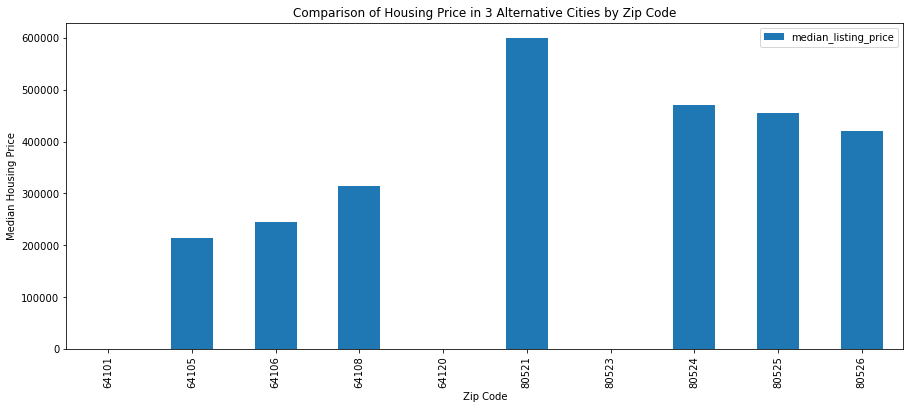

In [130]:
housing.plot(kind='bar', figsize=(15,6))

plt.xlabel('Zip Code')
plt.ylabel('Median Housing Price')
plt.title('Comparison of Housing Price in 3 Alternative Cities by Zip Code')
        
        
plt.show()